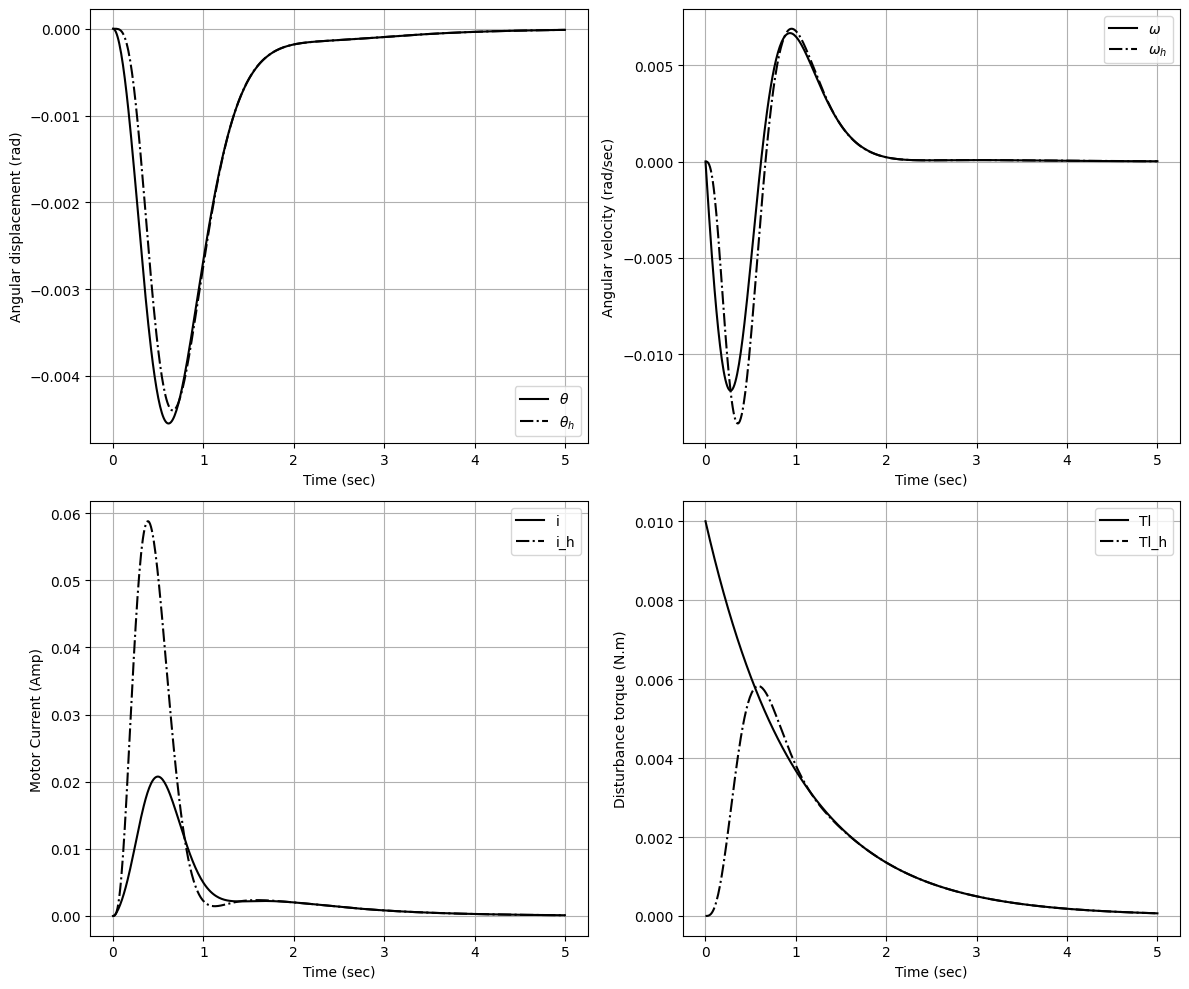

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Global parameter container
class Parameters:
    def __init__(self, Tl):
        self.Tl = Tl

# Define the function equivalent to DC_motor_LTR1
def DC_motor_LTR1(t, X, Par):
    # Model of The Real System
    x = X[:3]
    A = np.array([[0, 1, 0],
                  [0, 0, 4.438],
                  [0, -12, -24]])
    B = np.array([[0, 0],
                  [0, -7.396],
                  [20, 0]])
    C = np.array([1, 0, 0])
    y = C @ x

    # Model of the observer with disturbance Tl
    xh = X[3:]
    Ah = np.array([[0, 1, 0, 0],
                   [0, 0, 4.438, -7.396],
                   [0, -12, -24, 0],
                   [0, 0, 0, -1]])
    Bh = np.array([0, 0, 20, 0]).reshape(-1, 1)
    Ch = np.array([1, 0, 0, 0])

    # State feedback and state observer gains
    k = np.array([3.0000, 0.8796, 0.1529, -1.8190])
    G = np.array([-1.0000, 235.7440, -978.1707, -20.4870])

    # Final Equations
    Tl = Par.Tl * np.exp(-t)  # Exponential disturbance
    v = -k @ xh
    u = np.array([v, Tl])

    xhp = Ah @ xh + Bh.flatten() * v + G * (y - Ch @ xh)
    xp = A @ x + B @ u
    return np.concatenate((xp, xhp))

# Define the main simulation function
def main():
    # Define initial conditions and parameters
    X0 = np.zeros(7)  # Initial state vector
    Par = Parameters(Tl=0.01)  # Create an instance with disturbance parameter

    # Define the time span for the simulation
    t_span = (0, 5)
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # Solve the differential equations
    sol = solve_ivp(lambda t, X: DC_motor_LTR1(t, X, Par), t_span, X0, t_eval=t_eval, max_step=1e-2)

    t = sol.t
    x = sol.y.T

    # Plot the results
    plt.figure(figsize=(12, 10))

    plt.subplot(221)
    plt.plot(t, x[:, 0], 'k', label=r'$\theta$')
    plt.plot(t, x[:, 3], '-.k', label=r'$\theta_h$')
    plt.grid()
    plt.xlabel('Time (sec)')
    plt.ylabel('Angular displacement (rad)')
    plt.legend()

    plt.subplot(222)
    plt.plot(t, x[:, 1], 'k', label=r'$\omega$')
    plt.plot(t, x[:, 4], '-.k', label=r'$\omega_h$')
    plt.grid()
    plt.xlabel('Time (sec)')
    plt.ylabel('Angular velocity (rad/sec)')
    plt.legend()

    plt.subplot(223)
    plt.plot(t, x[:, 2], 'k', label='i')
    plt.plot(t, x[:, 5], '-.k', label='i_h')
    plt.grid()
    plt.xlabel('Time (sec)')
    plt.ylabel('Motor Current (Amp)')
    plt.legend()

    Tl = Par.Tl * np.exp(-t)
    plt.subplot(224)
    plt.plot(t, Tl, 'k', label='Tl')
    plt.plot(t, x[:, 6], '-.k', label='Tl_h')
    plt.grid()
    plt.xlabel('Time (sec)')
    plt.ylabel('Disturbance torque (N.m)')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
